# Pointsoup Project Setup
This notebook helps you set up, train, and evaluate the Pointsoup project locally or in Google Colab. Each step is described and paired with a code cell.

## 1. Clone or Pull the Repository
Clone the repository if it does not exist, or pull the latest changes if it does.

In [ ]:
import os
%cd ../
if not os.path.exists('Pointsoup'):
    !git clone https://github.com/rhmes/Pointsoup.git
else:
    %cd Pointsoup
    !git pull origin main

## 2. Set Up Conda Environment
Create and activate a conda environment in the `environment` directory. The environment will use GPU if available, otherwise CPU.

In [1]:
# Check if 'pointsoup' conda environment exists, activate if so, else create it
import os
import subprocess
def conda_env_exists(env_name):
    result = subprocess.run(['conda', 'env', 'list'], stdout=subprocess.PIPE, text=True)
    print("Checking for existing conda environment...")
    return any(env_name in line for line in result.stdout.splitlines())
env_name = 'pointsoup'
if conda_env_exists(env_name):
    print(f"Activating existing conda environment: {env_name}")
    !conda run -n {env_name} python --version
else:
    print(f"Creating conda environment: {env_name}")
    !bash environment/env_create.sh

Checking for existing conda environment...
Activating existing conda environment: pointsoup
Python 3.10.14



## 3. Train the Pointsoup Model
Train the Pointsoup model using the ModelNet40 dataset. This step will save training checkpoints to the `model/session/` directory. You can adjust training arguments as needed.

### Download and Prepare Dataset
Before training, download the ModelNet40 dataset (8192 points, train/test) from the link below. Extract the contents to the `data/ModelNet40_pc_01_8192p/` directory in your project workspace.
- [ModelNet40 (8192 points, train/test)](https://drive.google.com/file/d/1Isa8seckZ9oNzstlE7VZcd6wVVx8LdMF/view?usp=sharing)
**Usage:**
1. Click the link above and download the zip file.
2. Extract the contents to `data/ModelNet40_pc_01_8192p/` in your project directory.
3. Ensure the train and test `.ply` files are available for training and evaluation.

In [ ]:
# Train the Pointsoup model with custom arguments
!python train.py --model_save_folder ./model/session/ --train_glob "/data/ModelNet40_pc_01_8192p/**/train/*.ply" --lr 0.0005 --model_type pointsoup_sa

## 4. Evaluate the Model
First, evaluate the vanilla Pointsoup model, then evaluate the Pointsoup-SA model. The results will be compared in the next cell.

###  Evaluate the trained Pointsoup models on the repo-examples and compare their PSNR results.
- Evaluate the vanilla Pointsoup model on the repo-examples.
- Evaluate the Pointsoup-SA model on the same dataset.
- Compare the PSNR results from both runs using a plot.

In [8]:
!python evaluate.py --input_glob './data/example_pc_1023/*.ply' --compressed_path ./data/compressed_example --decompressed_path ./data/decompressed-example --model_load_path ./model/exp/ckpt.pt --model_type pointsoup


========== Process 1/3: Compression ==========
Using /Users/raghda/Library/Caches/torch_extensions/py310_cpu as PyTorch extensions root...
Using /Users/raghda/Library/Caches/torch_extensions/py310_cpu as PyTorch extensions root...
Emitting ninja build file /Users/raghda/Library/Caches/torch_extensions/py310_cpu/torchac_backend/build.ninja...
Building extension module torchac_backend...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module torchac_backend...
Emitting ninja build file /Users/raghda/Library/Caches/torch_extensions/py310_cpu/torchac_backend/build.ninja...
Building extension module torchac_backend...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module torchac_backend...
[PROC] Using Pointsoup model.
 Loaded legacy checkpoint (with remapping).
[PROC] Using Point

### Evaluate Pointsoup-SA Model
Run the evaluation script for the Pointsoup-SA model using the trained checkpoint and compare its results to the vanilla Pointsoup model.

In [64]:
!python evaluate.py --input_glob './data/example_pc_1023/*.ply' --compressed_path ./data/compressed_example_sa --decompressed_path ./data/decompressed-example_sa --model_load_path ./model/exp-sa/ckpt.pt --model_type pointsoup_sa


========== Process 1/3: Compression ==========
Using /Users/raghda/Library/Caches/torch_extensions/py310_cpu as PyTorch extensions root...
Emitting ninja build file /Users/raghda/Library/Caches/torch_extensions/py310_cpu/torchac_backend/build.ninja...
Building extension module torchac_backend...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module torchac_backend...
[PROC] Using Pointsoup Self-Attention model.
 Loaded legacy checkpoint (with remapping).
100%|█████████████████████████████████████████████| 2/2 [02:08<00:00, 64.04s/it]
Done. Avg. Encoding time: 63.944 | Bpp: 0.236

========== Process 2/3: Decompression ==========
Using /Users/raghda/Library/Caches/torch_extensions/py310_cpu as PyTorch extensions root...
Emitting ninja build file /Users/raghda/Library/Caches/torch_extensions/py310_cpu/torchac_backend/build.ninja...
Building extension module torchac_backend...
Allowi

### Visualize and Compare Results
This cell loads the PSNR results from both Pointsoup and Pointsoup-SA runs and plots them for direct comparison.

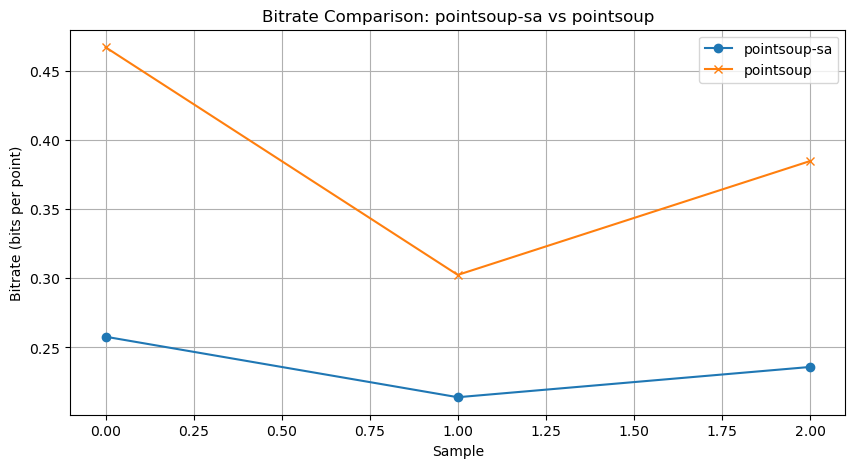

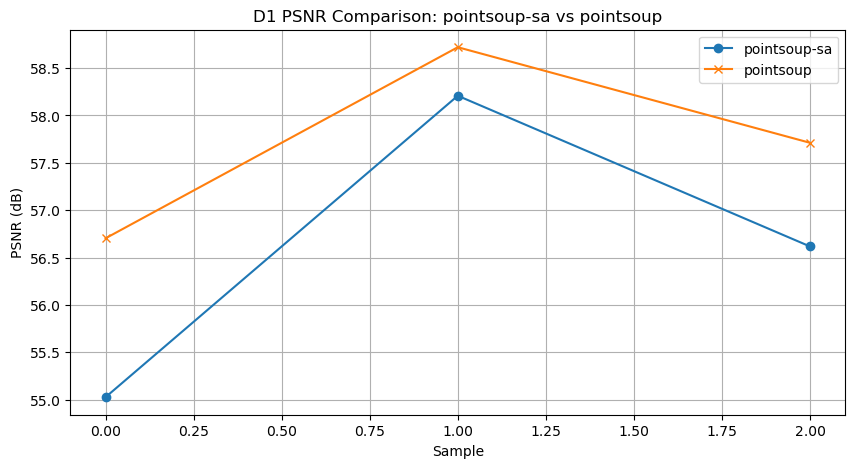

In [2]:
# Compare PSNR and bitrate results from pointsoup and pointsoup-sa runs
import pandas as pd
import matplotlib.pyplot as plt
psnr_sa_csv = './csv/decompressed-example_sa_psnr_results.csv'  # pointsoup-sa results
psnr_vanilla_csv = './csv/decompressed-example_psnr_results.csv'  # pointsoup results
df_sa = pd.read_csv(psnr_sa_csv)
df_vanilla = pd.read_csv(psnr_vanilla_csv)
# Bitrate comparison
plt.figure(figsize=(10,5))
plt.plot(df_sa['bpp'], marker='o', label='pointsoup-sa')
plt.plot(df_vanilla['bpp'], marker='x', label='pointsoup')
plt.title('Bitrate Comparison: pointsoup-sa vs pointsoup')
plt.xlabel('Sample')
plt.ylabel('Bitrate (bits per point)')
plt.legend()
plt.grid(True)
plt.show()
# PSNR comparison
plt.figure(figsize=(10,5))
plt.plot(df_sa['d1_psnr'], marker='o', label='pointsoup-sa')
plt.plot(df_vanilla['d1_psnr'], marker='x', label='pointsoup')
plt.title('D1 PSNR Comparison: pointsoup-sa vs pointsoup')
plt.xlabel('Sample')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.grid(True)
plt.show()